In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets evaluate sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
# Replace with the path to your zip file
train_path = "/content/drive/MyDrive/hateful_memes/train.jsonl" 
val_path = "/content/drive/MyDrive/hateful_memes/dev_seen.jsonl"

In [6]:
import pandas as pd

df_t = pd.read_json(train_path, lines=True)
df_val = pd.read_json(val_path, lines=True)


In [ ]:
df_t.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [7]:
df_t = df_t.loc[:, ['text', 'label']]
df_val = df_val.loc[:, ['text', 'label']]

In [8]:
df_t.head()

,text,label
0,its their character not their color that matters,0
1,don't be afraid to love again everyone is not ...,0
2,putting bows on your pet,0
3,i love everything and everybody! except for sq...,0
4,"everybody loves chocolate chip cookies, even h...",0


In [7]:
import re

# define a function to clean the text
def clean_text(text):
    # remove unwanted characters such as punctuation marks, special characters, etc.
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    
    # print the removed characters
    removed_text = re.sub(r'[\w\s]', '', text)
    print(f"Removed characters: {removed_text}")
    
    return cleaned_text

In [10]:
# apply the clean_text function to the 'label' column of the pandas dataframe
df_t['text'] = df_t['text'].apply(clean_text)

Streaming output truncated to the last 5000 lines.
Removed characters: ''
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: :
Removed characters: '!
Removed characters: '
Removed characters: ,
Removed characters: 
Removed characters: ''
Removed characters: :
Removed characters: $.$.
Removed characters: '
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: ?'
Removed characters: '...?
Removed characters: ,&..!!!
Removed characters: .
Removed characters: ,'
Removed characters: 
Removed characters: ?!!
Removed characters: '''
Removed characters: !'!'
Removed characters: "!"",,,,,,,,-,....!"
Removed characters: 
Removed characters: 
Removed characters: ''.''.,-
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: ""
Removed characters: 
Removed characters: 
Removed characters: ?,'
Removed characters: '....!!!
Removed characters: ,:
Removed characters: '-
R

In [11]:
df_t['text']

0        its their character not their color that matters
1       dont be afraid to love again everyone is not l...
2                                putting bows on your pet
3       i love everything and everybody except for squ...
4       everybody loves chocolate chip cookies even hi...
                              ...                        
8495                    nobody wants to hang auschwitz me
8496    when god grants you a child after 20 years of ...
8497    gays on social media equality body positivity ...
8498    having a bad day you could be a siamese twin a...
8499    i hate muslims too they take their religion to...
Name: text, Length: 8500, dtype: object

In [12]:
df_val['text'] = df_val['text'].apply(clean_text)

Removed characters: 
Removed characters: 
Removed characters: $.$.
Removed characters: ..
Removed characters: 
Removed characters: ,'
Removed characters: #
Removed characters: ',
Removed characters: !!!!
Removed characters: 
Removed characters: *
Removed characters: !!!
Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: 
Removed characters: 
Removed characters: ,"".!!!!
Removed characters: ''
Removed characters: 
Removed characters: 
Removed characters: .
Removed characters: (,)'
Removed characters: ?
Removed characters: ?
Removed characters: !
Removed characters: '?'
Removed characters: 
Removed characters: ,""
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: ,'??',
Removed characters: ?!!
Removed characters: ...
Removed characters: ?'
Removed characters: '
Removed characters: ...
Removed characters: ...
Removed characters: 
Removed characters: 
Removed cha

In [8]:
from transformers import BertTokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
# for validation set
#  Tokenize all of the sentences and map the tokens to thier word IDs.
def preprocess(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data['text']:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(data['label'])

    return input_ids, attention_masks,labels

In [16]:
input_ids,attention_masks,labels = preprocess(df_t)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
v_input_ids,v_attention_masks,v_labels = preprocess(df_val)

In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', df_t['text'][1])
print('Token IDs:', input_ids[1])

Original:  dont be afraid to love again everyone is not like your ex
Token IDs: tensor([ 101, 2123, 2102, 2022, 4452, 2000, 2293, 2153, 3071, 2003, 2025, 2066,
        2115, 4654,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
print('Original: ', df_val['text'][1])
print('Token IDs:', v_input_ids[1])

Original:  bravery at its finest
Token IDs: tensor([  101, 16534,  2012,  2049, 10418,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [18]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)
val_dataset = TensorDataset(v_input_ids, v_attention_masks, v_labels)



In [19]:
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

8,500 training samples
  500 validation samples


In [20]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [21]:
from transformers import BertTokenizer, BertForSequenceClassification

In [11]:
# fixing random seeds for reproducibility
import random
seed_val = 20

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# model 1 

In [ ]:
# Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# balancing the classes
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(df_t['label']), y = df_t['label'])
# class_wts = dict(zip(np.unique(train_labels), class_wts))

print(class_wts)

[0.77540595 1.40775091]


In [ ]:
total_steps = len(train_dataloader) * 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)

In [ ]:
# fixing random seeds for reproducibility
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
def train(model,train_loader):
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  num_steps = 0

  for step,batch in enumerate(train_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc


In [ ]:
def evaluate(model,validation_loader):
  total_loss = 0.0
  total_acc = 0.0

  model.eval()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  

  return avg_loss,avg_acc

In [ ]:
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

num_epochs = 8

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
  
  train_loss, train_acc = train(model,train_dataloader)
  valid_loss, valid_acc = evaluate(model,validation_dataloader)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)


  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 8
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Training Accuracy: 0.644 | Training Loss: 0.657 | Validation Accuracy: 0.512 | Validation Loss: 0.702

 Epoch 2 / 8
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Training Accuracy: 0.644 | Training Loss: 0.654 | Validation Accuracy: 0.512 | Validation Loss: 0.730

 Epoch 3 / 8
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Training Accuracy: 0.645 | Training Loss: 0.653 | Validation Accuracy: 0.512 | Validation Loss: 0.719

 Epoch 4 / 8
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Training Accuracy: 0.645 | Training Loss: 0.653 | Validation Accuracy: 0.512 | Validation Loss: 0.734

 Epoch 5 / 

In [ ]:
## plots

def plotLoss(train_loss, val_loss, EPOCHS ):

  #isLossPlot = true, then it is loss plot, else it is accuracy plot
  epochs = range(1, EPOCHS + 1)

  # Plotting the training and validation loss over the number of epochs
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [ ]:

def plotAccuracy(train_accuracy, val_accuracy, EPOCHS ):

  #isLossPlot = true, then it is loss plot, else it is accuracy plot
  epochs = range(1, EPOCHS + 1)

  # Plotting the training and validation loss over the number of epochs
  plt.plot(epochs, train_accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


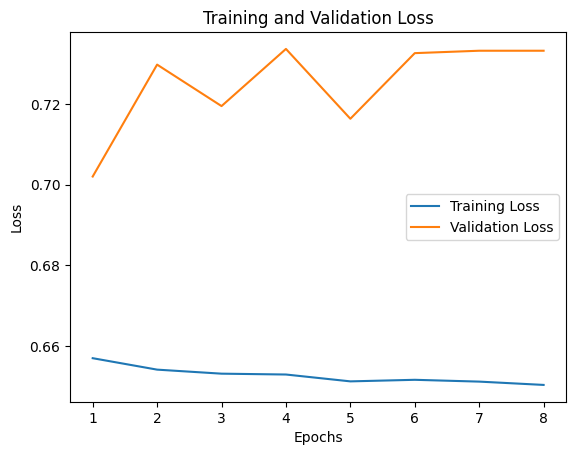

In [ ]:
plotLoss(train_losses, valid_losses, num_epochs)

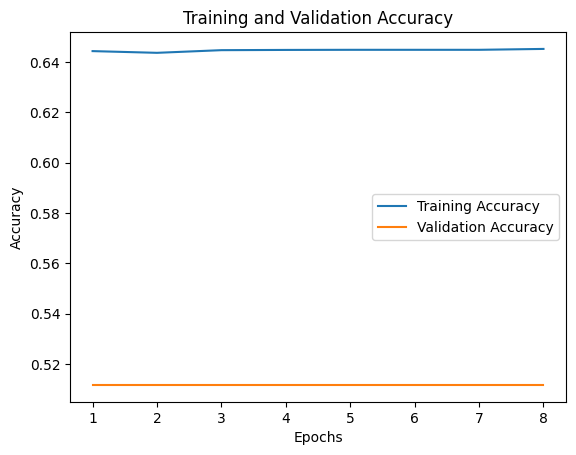

In [ ]:
plotAccuracy(train_accs, valid_accs, num_epochs)

# model 2

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,AutoModel

bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [28]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,100)

      self.relu1 = nn.ReLU()

      self.fc3 = nn.Linear(100,2)


      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      x = self.relu1(x)

      x = self.fc3(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [29]:
model2 = BERT_Arch(bert)

In [30]:
model2.to(device)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [31]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model2.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
import torch.optim as optim
optimizer = optim.Adadelta(model2.parameters(), lr=0.001)

In [32]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(df_t['label']), y = df_t['label'])
# class_wts = dict(zip(np.unique(train_labels), class_wts))

print(class_wts)

[0.77540595 1.40775091]


In [33]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
# cross_entropy  = nn.BCEWithLogitsLoss(weight=weights) 
cross_entropy  = nn.NLLLoss(weight=weights) 

In [34]:
# function to train the model
def train(model, train_dataloader):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
#     print(sent_id)
#     print(mask)
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()


    # calculate training accuracy
    preds_classes = np.argmax(preds.detach().cpu().numpy(), axis=1)
    accuracy = np.sum(preds_classes == labels.cpu().numpy()) / len(labels)
    total_accuracy += accuracy


    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss and accuracy of the epoch
  avg_loss = total_loss / len(train_dataloader)
  avg_accuracy = total_accuracy / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  print("avg train loss = ", avg_loss)
  print("avg train accuracy = ", avg_accuracy)
  # print("total_preds = ", total_preds)
  return avg_loss, avg_accuracy

In [35]:
# function for evaluating the model
def evaluate(model,validation_dataloader):
  
  
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 50 batches.
#     if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
#       elapsed = format_time(time.time() - t0)
            
      # Report progress.
#       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      # calculate validation accuracy
      preds_classes = np.argmax(preds.detach().cpu().numpy(), axis=1)
      accuracy = np.sum(preds_classes == labels.cpu().numpy()) / len(labels)
      total_accuracy += accuracy

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss and accuracy of the epoch
  avg_loss = total_loss / len(validation_dataloader) 
  avg_accuracy = total_accuracy / len(validation_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  print("avg eval loss = ", avg_loss)
  print("avg eval accuracy = ", avg_accuracy)


  return avg_loss,  avg_accuracy

In [36]:
train_losses=[]
valid_losses=[]
train_accuracy = []
val_accuracy = []

epochs = 10

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train(model2, train_dataloader)

    
    #evaluate model
    valid_loss, valid_acc = evaluate(model2,validation_dataloader)
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(valid_acc)
    
    print(f'\nTraining Accuracy : {train_acc:.6f}')
    print(f'Validation Accuracy : {valid_acc:.6f}')
    print(f'\nTraining Loss : {train_loss:.6f}')
    print(f'Validation Loss : {valid_loss:.6f}')


 Epoch 1 / 5
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6839209483530289
avg train accuracy =  0.5759868421052632
avg eval loss =  0.704844307154417
avg eval accuracy =  0.549609375

Training Accuracy : 0.575987
Validation Accuracy : 0.549609

Training Loss : 0.683921
Validation Loss : 0.704844

 Epoch 2 / 5
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6721527724337757
avg train accuracy =  0.5951127819548873
avg eval loss =  0.7135035470128059
avg eval accuracy =  0.54375

Training Accuracy : 0.595113
Validation Accuracy : 0.543750

Training Loss : 0.672153
Validation Loss : 0.713504

 Epoch 3 / 5
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6609650334917513
avg train accu

In [43]:
epochs = 25

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train(model2, train_dataloader)

    
    #evaluate model
    valid_loss, valid_acc = evaluate(model2,validation_dataloader)
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(valid_acc)
    



 Epoch 1 / 25
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6494458626983757
avg train accuracy =  0.6927631578947369
avg eval loss =  0.7757210284471512
avg eval accuracy =  0.54765625

 Epoch 2 / 25
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6423742749861309
avg train accuracy =  0.6852443609022557
avg eval loss =  0.7584256455302238
avg eval accuracy =  0.542578125

 Epoch 3 / 25
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6371044050481983
avg train accuracy =  0.687218045112782
avg eval loss =  0.7463003769516945
avg eval accuracy =  0.54453125

 Epoch 4 / 25
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch 

KeyboardInterrupt: ignored

In [ ]:
epochs = 10

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train(model2, train_dataloader)

    
    #evaluate model
    valid_loss, valid_acc = evaluate(model2,validation_dataloader)
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(valid_acc)



 Epoch 1 / 10
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6576447907022964
avg train accuracy =  0.6144736842105263
avg eval loss =  0.6844375729560852
avg eval accuracy =  0.55390625

 Epoch 2 / 10
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.651112993857018
avg train accuracy =  0.6205357142857143
avg eval loss =  0.6761058159172535
avg eval accuracy =  0.5640625

 Epoch 3 / 10
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.647733446574749
avg train accuracy =  0.6292763157894736
avg eval loss =  0.6906745918095112
avg eval accuracy =  0.56015625

 Epoch 4 / 10
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   2

In [ ]:
epochs = 1

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train(model2, train_dataloader)

    
    #evaluate model
    valid_loss, valid_acc = evaluate(model2,validation_dataloader)
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(valid_acc)



 Epoch 1 / 1
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.
avg train loss =  0.6305206204043295
avg train accuracy =  0.6484257518796992
avg eval loss =  0.7361213006079197
avg eval accuracy =  0.571875


In [ ]:
# saving model weights
torch.save(model2.state_dict(), 'A4_q2_bert.pth')

In [ ]:
#plotting graph

In [ ]:
def plotLoss(train_loss, val_loss ):
    loss_val = [x for x in val_loss]
    loss_train = [x for x in train_loss]

    plt.plot(loss_val, '-x', label='val')
    plt.plot(loss_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.title('LOSS vs. No. of epochs');


In [ ]:
def plotAccuracy(train_accuracy, val_accuracy ):

    accuracies_val = [x for x in val_accuracy]
    
    
    accuracies_train = [x for x in train_accuracy]
    # print(accuracies_val)
    # print(accuracies_train)

    plt.plot(accuracies_val, '-x', label='val')
    plt.plot(accuracies_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.title('Accuracy vs. No. of epochs');


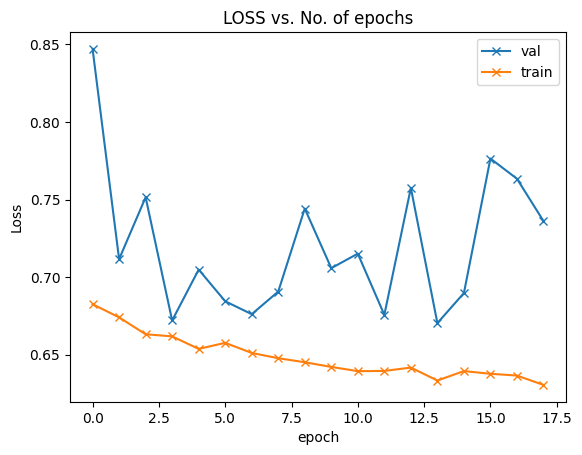

In [ ]:
plotLoss(train_losses, valid_losses)

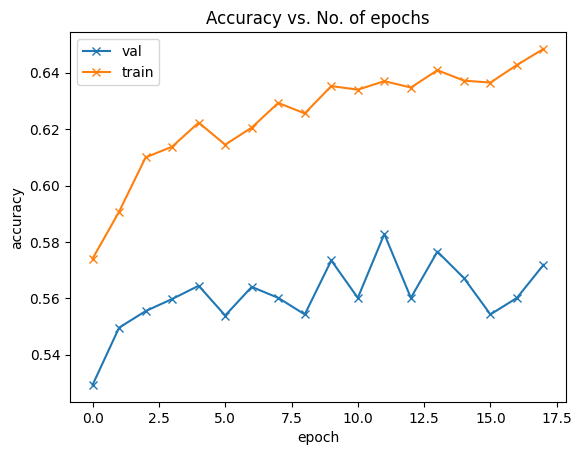

In [ ]:
plotAccuracy(train_accuracy, val_accuracy)

# section C best model is berut model with finetune with extra layer

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
# reloading model
model_path = '/content/drive/MyDrive/A4_q2_bert.pth'

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,AutoModel

loadbert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)


      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [34]:
lodedmodel = BERT_Arch(loadbert)

In [35]:
state_dict = torch.load(model_path)

In [36]:
lodedmodel.load_state_dict(state_dict)

<All keys matched successfully>

### loding testset

In [19]:
test_path = "/content/drive/MyDrive/hateful_memes/test_seen.jsonl"

In [20]:
import pandas as pd
df_test = pd.read_json(test_path, lines=True)

In [21]:
df_test = df_test.loc[:, ['text', 'label']]

In [22]:
df_test.head()

,text,label
0,handjobs sold seperately,1
1,introducing fidget spinner for women,1
2,happy pride month let's go beat up lesbians,1
3,laughs in [majority of u.s crime rate],1
4,finds out those 72 virgins.. are goats,1


In [59]:
len(df_test)

1000

In [23]:
df_test['text'] = df_test['text'].apply(clean_text)

Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: [.]
Removed characters: ..
Removed characters: .......
Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: ,,'
Removed characters: '
Removed characters: :':
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: '
Removed characters: 
Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: ?,!
Removed characters: ?
Removed characters: '
Removed characters: ..
Removed characters: ,,,?
Removed characters: 
Removed characters: ""
Removed characters: 
Removed characters: ?!
Removed characters: 
Removed characters: ..'
Removed characters: 
Removed characters: 
Removed characters: ....
Removed characters: '
Removed characters: 
Removed characters: 
Removed characters: '
Removed characters: ?...!!!
Removed characters: 
Removed characters: '''
Removed characters: 
Removed characters: 
Removed characters

In [24]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [25]:
input_idstest,attentiontest_masks,labelstest = preprocess(df_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
test_dataset = TensorDataset(input_idstest, attentiontest_masks, labelstest)

In [27]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
test_dataloader = DataLoader(
            test_dataset,  # The training samples.
             # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


In [65]:
len(test_dataloader)

32

In [66]:
def evaluatetest(model, validation_dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        # iterate over batches
        for step, batch in enumerate(validation_dataloader):
            sent_id = batch[0].to(device)
            mask = batch[1].to(device)
            labels = batch[2].to(device)

            preds = model(sent_id, mask)
            # calculate validation accuracy
            preds_classes = np.argmax(preds.cpu().detach().numpy(), axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds_classes)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')

        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1 score:', f1)


In [37]:
lodedmodel.to(device)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [32]:
type(lodedmodel)

__main__.BERT_Arch

In [68]:
evaluatetest(lodedmodel,test_dataloader)

Accuracy: 0.594
Precision: 0.6213872832369942
Recall: 0.4387755102040816
F1 score: 0.5143540669856459


In [69]:
def evaluateclasswisetest(model, validation_dataloader,num_classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        # iterate over batches
        for step, batch in enumerate(validation_dataloader):
            sent_id = batch[0].to(device)
            mask = batch[1].to(device)
            labels = batch[2].to(device)
            

            preds = model(sent_id, mask)
            # calculate validation accuracy
            preds_classes = np.argmax(preds.cpu().detach().numpy(), axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds_classes)

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])

    print('Accuracy:', accuracy)
    print('Classification Report:')
    print(report)


In [70]:
evaluateclasswisetest(lodedmodel,test_dataloader,2)

Accuracy: 0.594
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.74      0.65       510
     Class 1       0.62      0.44      0.51       490

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.58      1000
weighted avg       0.60      0.59      0.58      1000



## testset seen acuracy = 0.59

# Tsne

In [29]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

def visualize_tsne(features,ground_labels):


  zero_indices = [i for i, l in enumerate(ground_labels) if l == 0][:100]
  one_indices = [i for i,l in enumerate(ground_labels) if l == 1][:100]
  
  labels0 = ground_labels.take(zero_indices)
  labels1 = ground_labels.take(one_indices)
  labels = np.concatenate((labels0,labels1))
  
  features0 = features.take(zero_indices,axis = 0)
  features1 = features.take(one_indices,axis = 0)
  features_l = np.concatenate((features0,features1),axis = 0)

  tsne = TSNE(n_components=2,verbose = 1,random_state = 123).fit_transform(features_l)


  df = pd.DataFrame()
  df["y"] = labels
  df["comp-1"] = tsne[:,0]
  df["comp-2"] = tsne[:,1]
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                  palette=sns.color_palette("hls", 10),
                  data=df).set(title="Text Only Features TSNE Projections")


In [39]:
import torch

def postprocessing(data_loader, model):
    device = model.device
    features = None
    ground_labels = None
    
    with torch.no_grad():
        for batch in data_loader:
            sent_id, mask, labels = batch
            sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.numpy()
            
            _, cls_hs = model.bert(sent_id, mask)
            output = torch.flatten(cls_hs, 1).detach().cpu().numpy()

            if features is None:
                features = output
            else:
                features = np.concatenate((features, output), axis=0)

            if ground_labels is None:
                ground_labels = labels
            else:
                ground_labels = np.concatenate((ground_labels, labels), axis=0)
      
    return features, ground_labels


In [40]:
features,ground_labels = postprocessing(test_dataloader, lodedmodel)


<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>

<class '__main__.BERT_Arch'>


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.049952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.677322
[t-SNE] KL divergence after 1000 iterations: 0.351709


<ipython-input-29-2338002a1f2a>:26: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


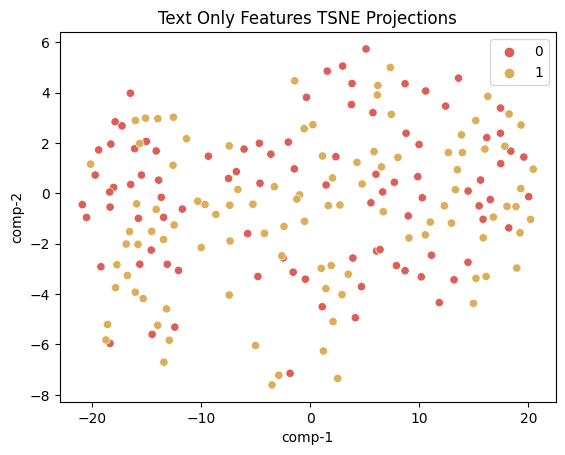

In [41]:
visualize_tsne(features,ground_labels)